In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

pd.options.display.max_columns = 25

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import os
# print(os.listdir(os.path.join('gdrive', 'MyDrive', 'Colab Notebooks', 'Business Analytics'))) # this is specific to your Drive
# print(os.chdir(os.path.join('gdrive', 'MyDrive', 'Colab Notebooks', 'Business Analytics'))) # this is specific to your Drive
os.chdir(os.path.join('gdrive', 'MyDrive', 'Fall 2022 MSDABC Marketing Analytics', 'Churn assignment'))
print(os.listdir())

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'gdrive\\MyDrive\\Fall 2022 MSDABC Marketing Analytics\\Churn assignment'

In [44]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [13]:
# ----- READ IN DATA -----
df = pd.read_csv('C:\\Users\\Ruofan Mo\\Desktop\\NYU_fall\\Marketing Analytics\\final project\\Copy of subscribers.xlsx')
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8d in position 12: invalid start byte

In [19]:
df = pd.read_pickle("subscribers")
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

In [20]:
df

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,...,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,...,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,...,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,...,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,UAE,facebook,...,4.5141,2019-11-17 14:12:33,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,UAE,google_organic,...,4.5141,2019-12-06 18:02:13,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,UAE,facebook,...,4.5141,2019-12-21 19:40:44,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-17 23:58:51,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [25]:
df.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,...,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,...,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,...,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,...,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


In [30]:
# ----- FIT CHURN MODEL ------
#y_col_name = 'churn_TF'
y_col_name = 'cancel_before_trial_end' #specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
#x_col_name = ['age', 'income', 'hours', 'female']
x_col_name = ['paid_TF', 'initial_credit_card_declined']# list of x covariates
add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    columns = ["subid", "package_type", "num_weekly_services_utilized", "preferred_genre", "intended_use", "weekly_consumption_hour", "num_ideal_streaming_services", "retarget_TF", "age", "male_TF", "country", "attribution_technical", "attribution_survey", "op_sys","months_per_bill_period", "plan_type", "monthly_price", "discount_price", "account_creation_date", "creation_until_cancel_days", "cancel_before_trial_end", "trial_end_date", "initial_credit_card_declined", "revenue_net", "join_fee", "language", "paid_TF", "refund_after_trial_TF", "payment_type", "const"]
    df = df.reindex(columns=columns)
    #x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())

# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


RESULTS OF LOGIT MODEL FITTING

                                   OLS Regression Results                                   
Dep. Variable:     cancel_before_trial_end   R-squared (uncentered):                -330.500
Model:                                 OLS   Adj. R-squared (uncentered):           -330.504
Method:                      Least Squares   F-statistic:                         -7.943e+04
Date:                     Wed, 14 Dec 2022   Prob (F-statistic):                        1.00
Time:                             15:19:30   Log-Likelihood:                      2.6588e+05
No. Observations:                   159339   AIC:                                 -5.318e+05
Df Residuals:                       159337   BIC:                                 -5.317e+05
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                   co

C:\Users\Ruofan Mo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



RESULTS OF LOGIT MODEL FITTING

                              Logit Regression Results                             
Dep. Variable:     cancel_before_trial_end   No. Observations:               159339
Model:                               Logit   Df Residuals:                   159337
Method:                                MLE   Df Model:                            1
Date:                     Wed, 14 Dec 2022   Pseudo R-squ.:                  0.4502
Time:                             15:19:33   Log-Likelihood:                -60372.
converged:                           False   LL-Null:                   -1.0980e+05
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
paid_TF                         30.7325   1.86e+04      0.002      0.999   -3.63e+04    3.64e+04
init

In [49]:
x_col_name = ["paid_TF"]


In [74]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['cancel_before_trial_end'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['initial_credit_card_declined'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['paid_TF'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

ValueError: shapes (68289,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [51]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

KeyError: 'churn_TF'

In [52]:
df["cancel_before_trial_end"].value_counts()

Series([], Name: cancel_before_trial_end, dtype: int64)

In [53]:
df["cancel_before_trial_end"]

162502   NaN
380374   NaN
496617   NaN
356799   NaN
681701   NaN
          ..
509326   NaN
229587   NaN
281340   NaN
87198    NaN
598241   NaN
Name: cancel_before_trial_end, Length: 227628, dtype: float64

In [54]:
df

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,const
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df = pd.read_pickle("subscribers")

In [56]:
df

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,...,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,...,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,...,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,...,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,UAE,facebook,...,4.5141,2019-11-17 14:12:33,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,UAE,google_organic,...,4.5141,2019-12-06 18:02:13,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,UAE,facebook,...,4.5141,2019-12-21 19:40:44,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,...,4.5141,2020-01-17 23:58:51,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [57]:
df["cancel_before_trial_end"].value_counts()

False    124071
True     103557
Name: cancel_before_trial_end, dtype: int64

In [58]:
df["male_TF"].value_counts()

False    200902
True      26457
Name: male_TF, dtype: int64

In [59]:
#churn rate = 103557/(124071+103557)=45.49%
#male = (26457)/(200902+26457) = 11.64%

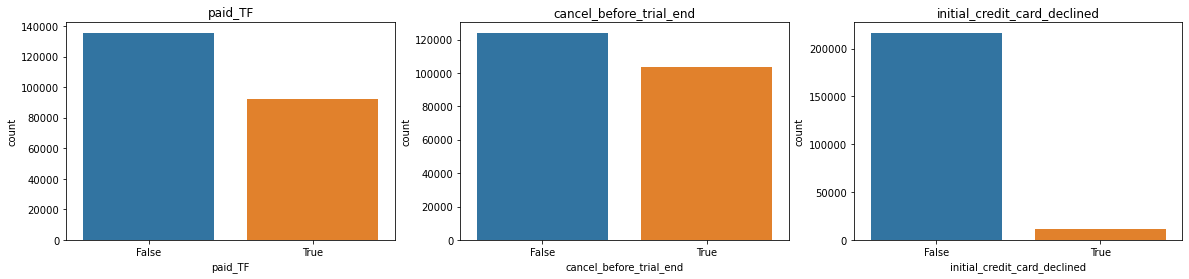

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

cols = ['paid_TF','cancel_before_trial_end','initial_credit_card_declined']
numerical = cols

plt.figure(figsize=(20,4))

for i, col in enumerate(numerical):
    ax = plt.subplot(1, len(numerical), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f"{col}")

<AxesSubplot:xlabel='cancel_before_trial_end', ylabel='join_fee'>

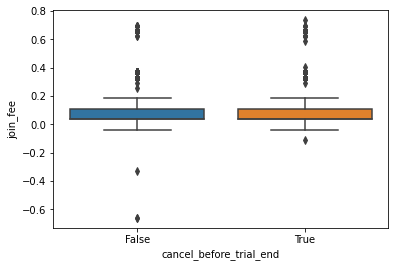

In [62]:
sns.boxplot(x='cancel_before_trial_end', y='join_fee', data=df)

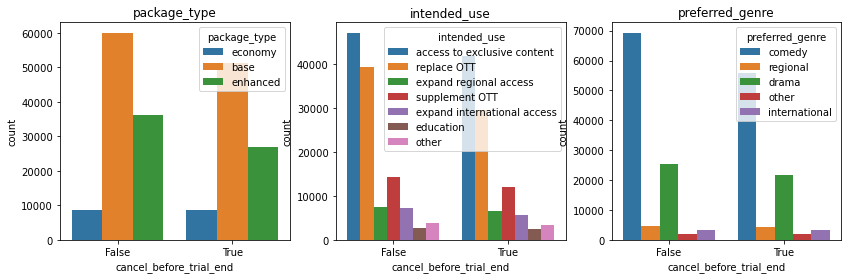

In [63]:
cols = ['package_type','intended_use','preferred_genre']

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ='cancel_before_trial_end', hue = str(col), data = df)
    ax.set_title(f"{col}")

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227628 entries, 162502 to 598241
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   subid                         227628 non-null  int64         
 1   package_type                  192054 non-null  object        
 2   num_weekly_services_utilized  117178 non-null  float64       
 3   preferred_genre               191302 non-null  object        
 4   intended_use                  224079 non-null  object        
 5   weekly_consumption_hour       189698 non-null  float64       
 6   num_ideal_streaming_services  115458 non-null  float64       
 7   retarget_TF                   227628 non-null  bool          
 8   age                           192459 non-null  float64       
 9   male_TF                       227359 non-null  object        
 10  country                       227628 non-null  object        
 11  attribut

In [66]:
df['package_type'] = df['package_type'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['preferred_genre'] = df['preferred_genre'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['male_TF'] = df['male_TF'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['country'] = df['country'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['attribution_technical'] = df['attribution_technical'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['attribution_survey'] = df['attribution_survey'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['op_sys'] = df['op_sys'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['plan_type'] = df['plan_type'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['language'] = df['language'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
df['payment_type'] = df['payment_type'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [68]:
cat_features = df
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_cat = cat_features.apply(le.fit_transform)
df_cat.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,...,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,39373,0,5329,0,0,81,25378,0,278,0,0,0,...,8,166715,275,1,208,0,383,20,0,1,0,0
380374,77474,0,5329,0,0,31,25378,0,73,0,0,0,...,8,200794,4,0,245,0,39,12,0,0,0,0
496617,156256,0,2557,0,5,54,12676,0,11,1,0,0,...,8,128302,5,0,160,0,39,7,0,0,0,0
356799,214454,0,5329,0,5,24,25378,0,16,0,0,0,...,8,168865,4,0,211,0,39,5,0,0,0,0
681701,153518,0,3045,0,5,31,20913,0,14,0,0,0,...,8,76522,13,0,97,0,39,5,0,0,0,0


In [71]:
from sklearn.model_selection import train_test_split

finaldf = df_cat.dropna()

X = df_cat.drop(['cancel_before_trial_end'],axis=1)
y = df_cat['cancel_before_trial_end']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [72]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

In [73]:
y_train.value_counts()

1    83223
0    83223
Name: cancel_before_trial_end, dtype: int64

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=46)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=46)

In [76]:
from sklearn.metrics import accuracy_score

preds = rf.predict(X_test)
print(accuracy_score(preds,y_test))

0.999840251337895
